In [5]:
import autoreload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import ModelLeaf
from ModelLeafInfer import *
import collections

In [11]:
GROUND_TRUTH_MIN_SIZE_COEFF = 0.05  # 0.03    0.05
def _calculate_IoU(image_name, detected_masks, ground_truth_dir, single_mask=True):
    # AZ start validation of single image
    # TODO - log/results file

    # get ground truth masks for this image
    # note: this should be done only once for each validation image (if train, do it once at the beginning, not after each epoch).
    image_name_prefix = image_name.split(".")[0] + "_GT_"
    num_gt_masks = 0
    h = detected_masks.shape[0]
    w = detected_masks.shape[1]
    gt_min_size = GROUND_TRUTH_MIN_SIZE_COEFF * GROUND_TRUTH_MIN_SIZE_COEFF * h * w
    
    gt_file_names = []
    for root, dirs, files in os.walk(ground_truth_dir):
        for file in files:
            if file.startswith(image_name_prefix):
                # read GT file, and use the GT only if num_pixels in mask > Threshold
                tmp = np.array(Image.open(ground_truth_dir + file))
                tmp_size = np.count_nonzero(tmp)
                if tmp_size > gt_min_size:
                    gt_file_names.append(file)
                    num_gt_masks = num_gt_masks + 1

    gt_masks = np.zeros([h,w,num_gt_masks])
    for i in range(num_gt_masks):
        curr_gt_file = ground_truth_dir + gt_file_names[i]
        curr_mask = np.array(Image.open(curr_gt_file))
        gt_masks[:,:,i] = curr_mask
    # create empty IoU matrix M (num_ground_truth_masks x num detected_masks)
    # note: if validation during training - this should be done after each epoch.
    num_of_detected_masks = detected_masks.shape[2]
    all_iou = np.zeros(shape=[num_gt_masks, num_of_detected_masks])

    # fill IoU matrix
    # for each mask m1 in ground truth
    #   for each mask m2 in detected
    #       M(m1,m2) = IoU(m1,m2)
    for i in range(num_gt_masks):
        mask_i = gt_masks[:,:,i]
        for j in range(num_of_detected_masks):
            mask_j = detected_masks[:,:,j]
            intersection = np.logical_and(mask_i,mask_j)
            union = np.logical_or(mask_i,mask_j)
            numI = np.count_nonzero(intersection)
            numU = np.count_nonzero(union)
            all_iou[i,j] = numI/numU

    # calculate total (or average) IoU
    curr_score = 0
    for i in range(num_gt_masks):
        # find max value and indices of max value
        max_iou = np.amax(all_iou)
        curr_score = curr_score + max_iou
        max_idx = np.argmax(all_iou)
        max_idx_row, max_idx_col = divmod(max_idx, all_iou.shape[1])

        # remove row/col of max value (set zeros)
        for j in range(all_iou.shape[1]):
            all_iou[max_idx_row,j] = 0
        for j in range(all_iou.shape[0]):
            all_iou[j,max_idx_col] = 0

    if num_gt_masks > 0:
        curr_score = curr_score / num_gt_masks
    else:
        curr_score = 1

    return curr_score
    # AZ end validation of single image





  0%|          | 0/4 [00:00<?, ?it/s]

Re-starting from epoch 9


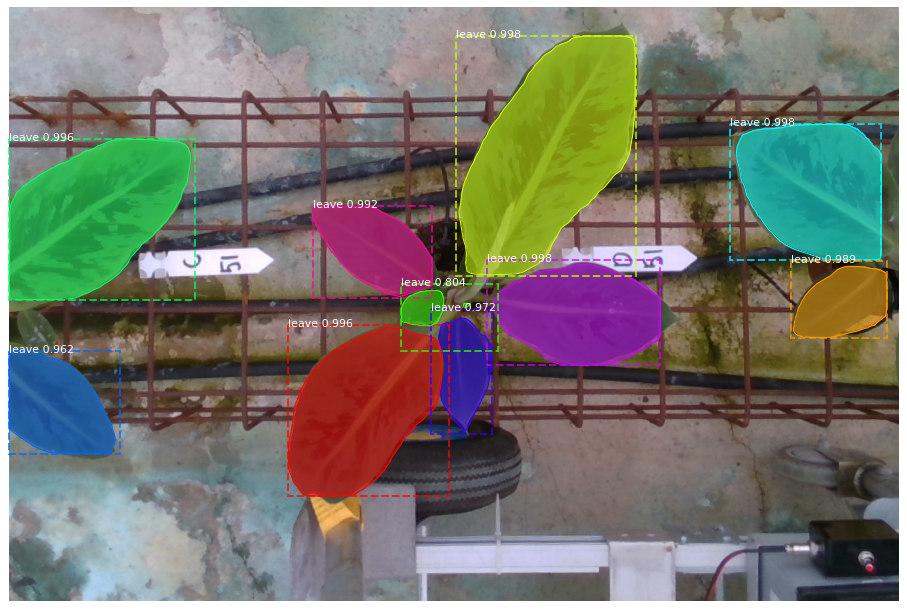




 25%|██▌       | 1/4 [01:02<03:08, 62.97s/it]

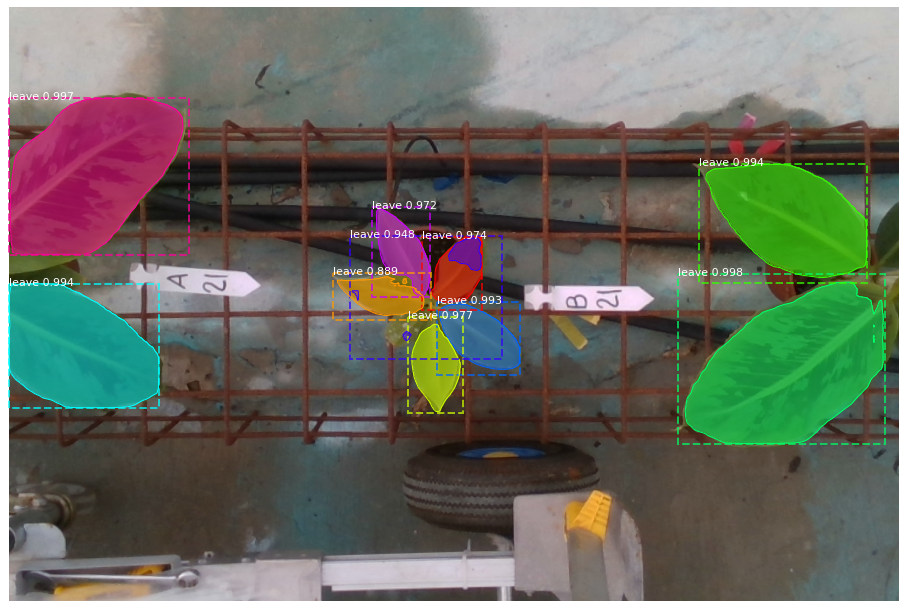




 50%|█████     | 2/4 [02:00<02:02, 61.24s/it]

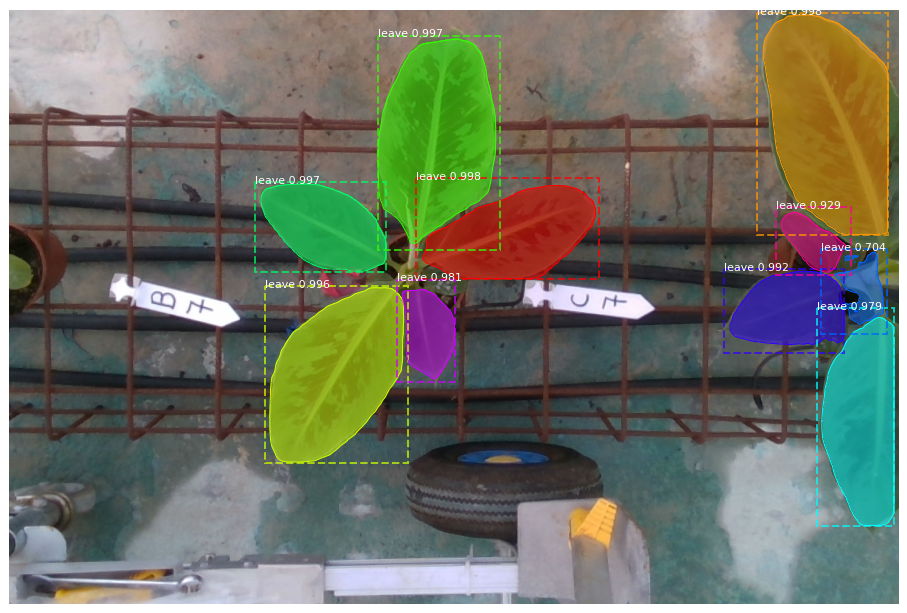




 75%|███████▌  | 3/4 [03:02<01:01, 61.70s/it]

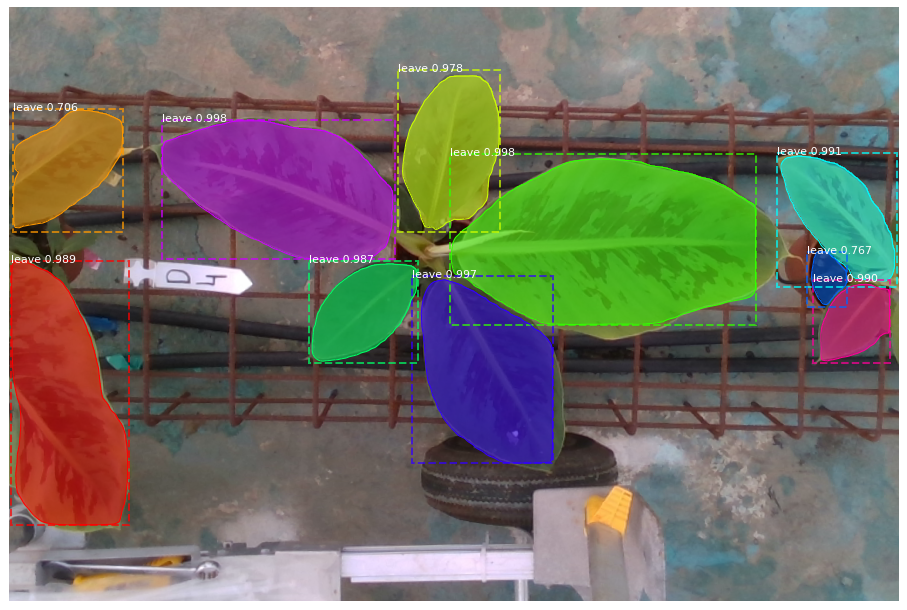




100%|██████████| 4/4 [04:04<00:00, 61.09s/it]


In [16]:
Args = collections.namedtuple('Args', 'path output no_pictures no_contours model no_masks gt')

args = Args(path='/home/simonl/datasets/inference_input',
           output='out_dir',
           no_pictures=False,
           no_contours=False,
           model='models/leaves20200104T1646/mask_rcnn_leaves_0009.h5',
           no_masks=False,
           gt='/home/simonl/datasets/gt_masks_single/')

from mrcnn.model import MaskRCNN
infer_path = args.path
output = args.output
do_pictures = not args.no_pictures
do_contours = not args.no_contours
model_path = args.model
should_save_masks = not args.no_masks
compare_to_gt = args.gt != ""
gt_dir = args.gt

# Retrieve images
images = generate_images(infer_path)

# Retrieve model path
model_path = prompt_model(model_path)

# Load model
inference_config = get_inference_config(ModelLeafConfig)
if not os.path.exists(output):
    os.makedirs(output, exist_ok=True)
model = MaskRCNN(mode="inference", config=inference_config, model_dir=output)
model.load_weights(model_path, by_name=True)
model.set_log_dir()

output_dir = model.log_dir
os.makedirs(output_dir, exist_ok=True)

# Infer
inference_dict = {}
IoU_dict = {}
for image_path in tqdm(list(images)):
    inference_dict[image_path] = []
    image_name = os.path.basename(image_path)
    image = np.array(Image.open(image_path))
    r = model.detect([image])[0]
    if should_save_masks:
        save_masks(r, output_dir, image_name)

    if do_pictures:
        output_file_path = os.path.join(output_dir, image_name)
        visualize.save_instances(image, r['rois'], r['masks'], r['class_ids'],
                                ['BG', 'leave'], r['scores'], save_to=output_file_path,)

    if do_contours:
        inference_dict[image_path], txt_contours  = get_contours(r)

        for i, leaf_contour in enumerate(txt_contours):
            for j, polygon_contour in enumerate(leaf_contour):
                contour_file_name = os.path.join(output_dir, os.path.splitext(image_name)[0]) + \
                "_" + str(i).zfill(3) + "_" + str(j) + ".txt"
                np.savetxt(contour_file_name, polygon_contour, fmt='%.1f', delimiter=' , ')


    if compare_to_gt:
        IoU_dict[image_path] = _calculate_IoU(image_name, r['masks'], gt_dir)


if do_contours:
    with open(os.path.join(output_dir, CONTOUR_FILE_NAME), 'w') as f:
        f.write(json.dumps(inference_dict, indent=2))

In [ ]:
import json
print(json.dumps(IoU_dict, indent=2))